# Apartment for rent classified
This notebook contains the stages to execute an end-to-end process to obtain a regression model of apartment rent based on their characteristics.

## Setup

In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

## Load data

In [2]:
train_df = pd.read_csv(r"..\data\raw\apartments_for_rent_classified_100K.csv", sep=";", encoding='cp1252')
test_df = pd.read_csv(r"..\data\raw\apartments_for_rent_classified_10K.csv",  sep=";", encoding='cp1252')

C:\Users\H483882\AppData\Local\Temp\ipykernel_47492\3653544847.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r"..\data\raw\apartments_for_rent_classified_100K.csv", sep=";", encoding='cp1252')


In [3]:
print('\033[1m'"Shape of the train data file\n"'\033[0m',train_df.shape)
print('\033[1m'"Shape of the test data file\n"'\033[0m',test_df.shape)

Shape of the train data file
 (99492, 22)
Shape of the test data file
 (10000, 22)


In [4]:
# Getting the count of the numerical and categorical columns in the train dataset
def count_categorical_numerical_columns(df)-> Tuple[int, int]:
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    num_categorical_columns = len(categorical_columns)
    
    # Select numerical columns
    numerical_columns = df.select_dtypes(exclude=['object']).columns
    num_numerical_columns = len(numerical_columns)    
    return num_categorical_columns, num_numerical_columns

num_categorical, num_numerical = count_categorical_numerical_columns(train_df)
print("Number of categorical columns:", num_categorical)
print("Number of numerical columns:", num_numerical)

Number of categorical columns: 14
Number of numerical columns: 8


In [5]:
# Combine the datasets
data = pd.concat([train_df, test_df], ignore_index=True)
# Shuffle the combined dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
display(data.head())

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5509055389,housing/rent/apartment,"Lovely Suwanee, Two BR, Two BA","Square footage: 1076 sq-ft, unit number: 1511....","AC,Cable or Satellite,Clubhouse,Dishwasher,Ele...",2.0,2.0,USD,No,Yes,...,"$1,920",Monthly,1076,NaN,Suwanee,GA,34.0648,-84.0849,RentDigs.com,1568770687
1,5198602576,housing/rent/apartment,Apartment in prime location,"Square footage: 965 sq-ft, unit number: 0905. ...","AC,Cable or Satellite,Clubhouse,Gated,Gym,Inte...",1.0,1.0,USD,No,Thumbnail,...,$973,Monthly,965,NaN,Shreveport,LA,32.4544,-93.7135,RentDigs.com,1550862874
2,5668639190,housing/rent/apartment,Studio apartment 1475 W. Adams Blvd.,"This unit is located at 1475 W. Adams Blvd., L...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,585",Monthly,600,1475 W Adams Boulevard,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360294
3,5668620791,housing/rent/apartment,"One BR 2032 Tx 361,","This unit is located at 2032 Tx 361,, Inglesid...","Cable or Satellite,Clubhouse,Dishwasher,Gated,...",1.0,1.0,USD,No,Thumbnail,...,$950,Monthly,722,2032 TX 361,Ingleside,TX,27.8689,-97.2057,RentLingo,1577359020
4,5509228509,housing/rent/apartment,"Average Rent $1,275 a month - That's a STEAL!",If you think you can t afford to live on a 36-...,"Parking,Pool,Tennis",1.0,2.0,USD,No,Thumbnail,...,"$1,275",Monthly,960,NaN,East Hartford,CT,41.7588,-72.6148,RentDigs.com,1568780032


## EDA

In [6]:
# Drop duplicates
data = data.drop_duplicates()

In [7]:
# Get missing values
data.isna().mean() * 100

id                0.000000
category          0.000000
title             0.000000
body              0.000000
amenities        16.129584
bathrooms         0.063364
bedrooms          0.124716
currency          0.000000
fee               0.000000
has_photo         0.000000
pets_allowed     55.635347
price             0.001006
price_display     0.001006
price_type        0.000000
square_feet       0.000000
address          92.012150
cityname          0.303743
state             0.303743
latitude          0.025144
longitude         0.025144
source            0.000000
time              0.000000
dtype: float64

In [8]:
# fill missing values
for col in ['bathrooms', 'bedrooms', 'latitude', 'longitude']:
    data[col] = data[col].fillna(data[col].median())

data['pets_allowed'] = data['pets_allowed'].fillna('unknown')

In [9]:
# Drop unnecessary columns
data = data.drop(columns=["id", "title", "body", "time", "price_display"])

In [10]:
# Descriptive statistics
pd.set_option('display.float_format', '{:.4f}'.format)
display(data.describe().round(4).T)
display(data.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
bathrooms,99426.0000,1.4450,0.5470,1.0000,1.0000,1.0000,2.0000,9.0000
bedrooms,99426.0000,1.7285,0.7489,0.0000,1.0000,2.0000,2.0000,9.0000
price,99425.0000,1527.1731,904.4109,100.0000,1014.0000,1350.0000,1795.0000,52500.0000
square_feet,99426.0000,956.4433,417.6701,101.0000,729.0000,900.0000,1115.0000,50000.0000
latitude,99426.0000,36.9479,4.5997,19.5738,33.7465,37.2258,39.9533,64.8332
longitude,99426.0000,-91.5645,15.8163,-159.3698,-104.7919,-84.5623,-77.6066,-68.7788


,count,unique,top,freq
category,99426,7,housing/rent/apartment,99365
amenities,83389,9827,Parking,6183
currency,99426,1,USD,99426
fee,99426,2,No,99225
has_photo,99426,3,Yes,55915
pets_allowed,99426,6,unknown,55316
price_type,99426,3,Monthly,99422
address,7942,7771,8215 S.W 72nd Avenue,19
cityname,99124,2979,Dallas,2856
state,99124,51,TX,11252


In [11]:
categorical_columns =  data.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if data[col].nunique() < 10]
# Selecting numerical columns
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns = [col for col in numerical_columns if col not in ['id', 'time']]
# Creating DataFrame with only categorical columns
categorical_data = data[categorical_columns]
# Creating DataFrame with only numerical columns
numerical_data = data[numerical_columns]

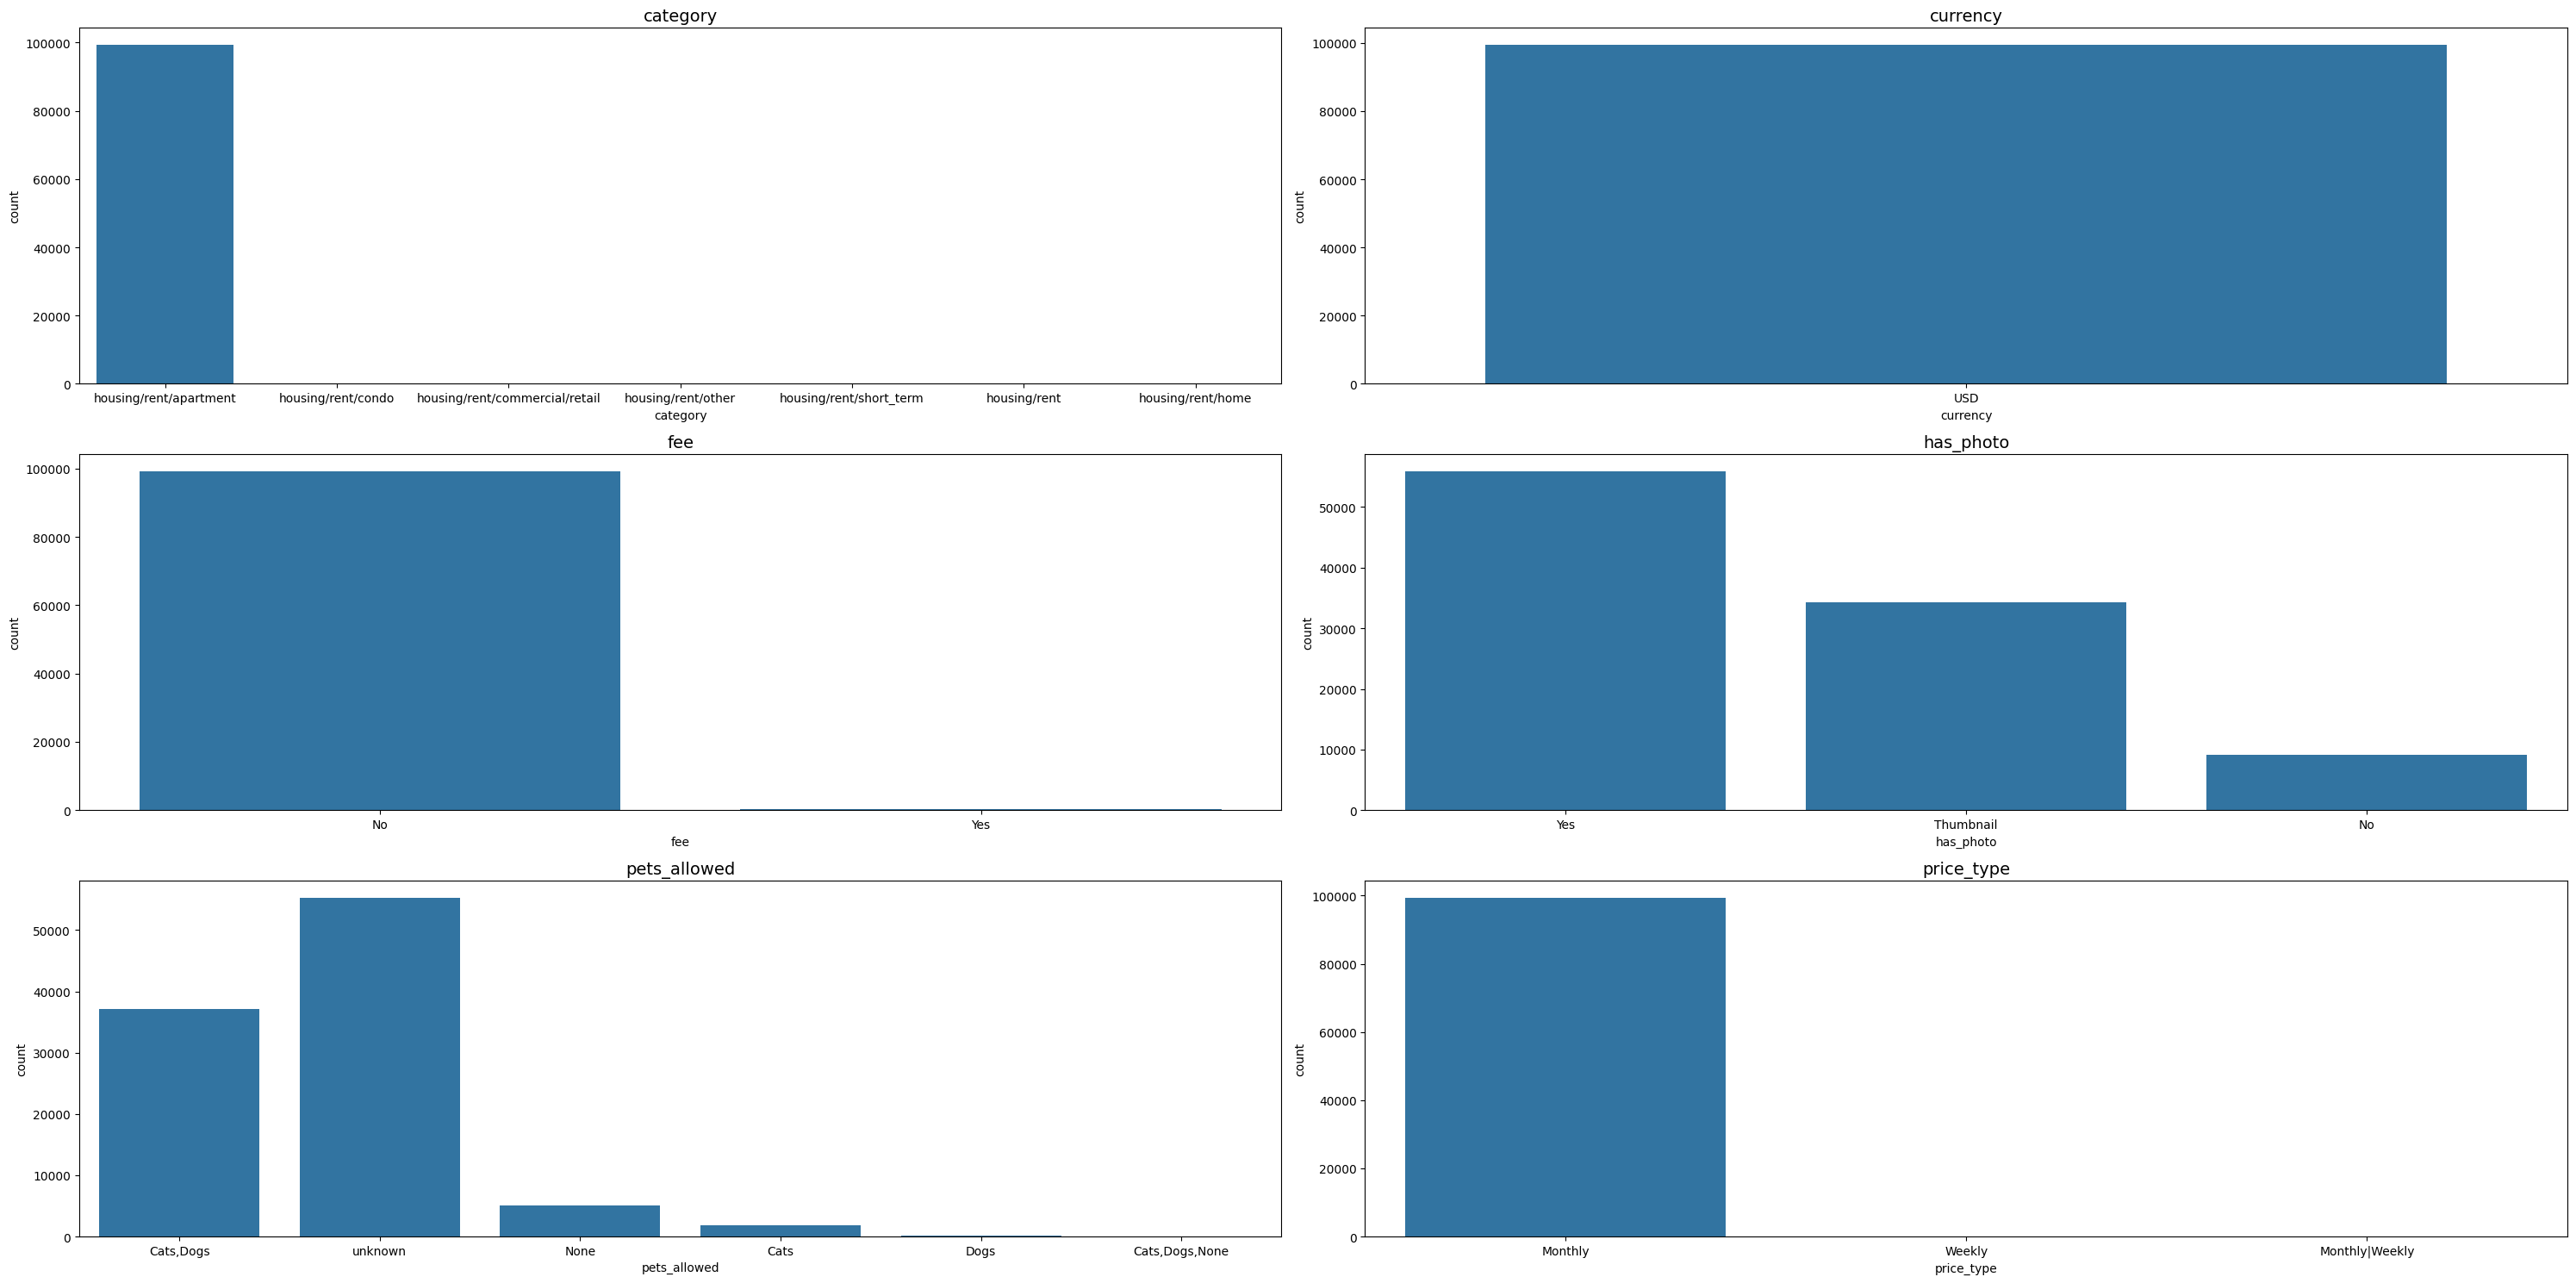

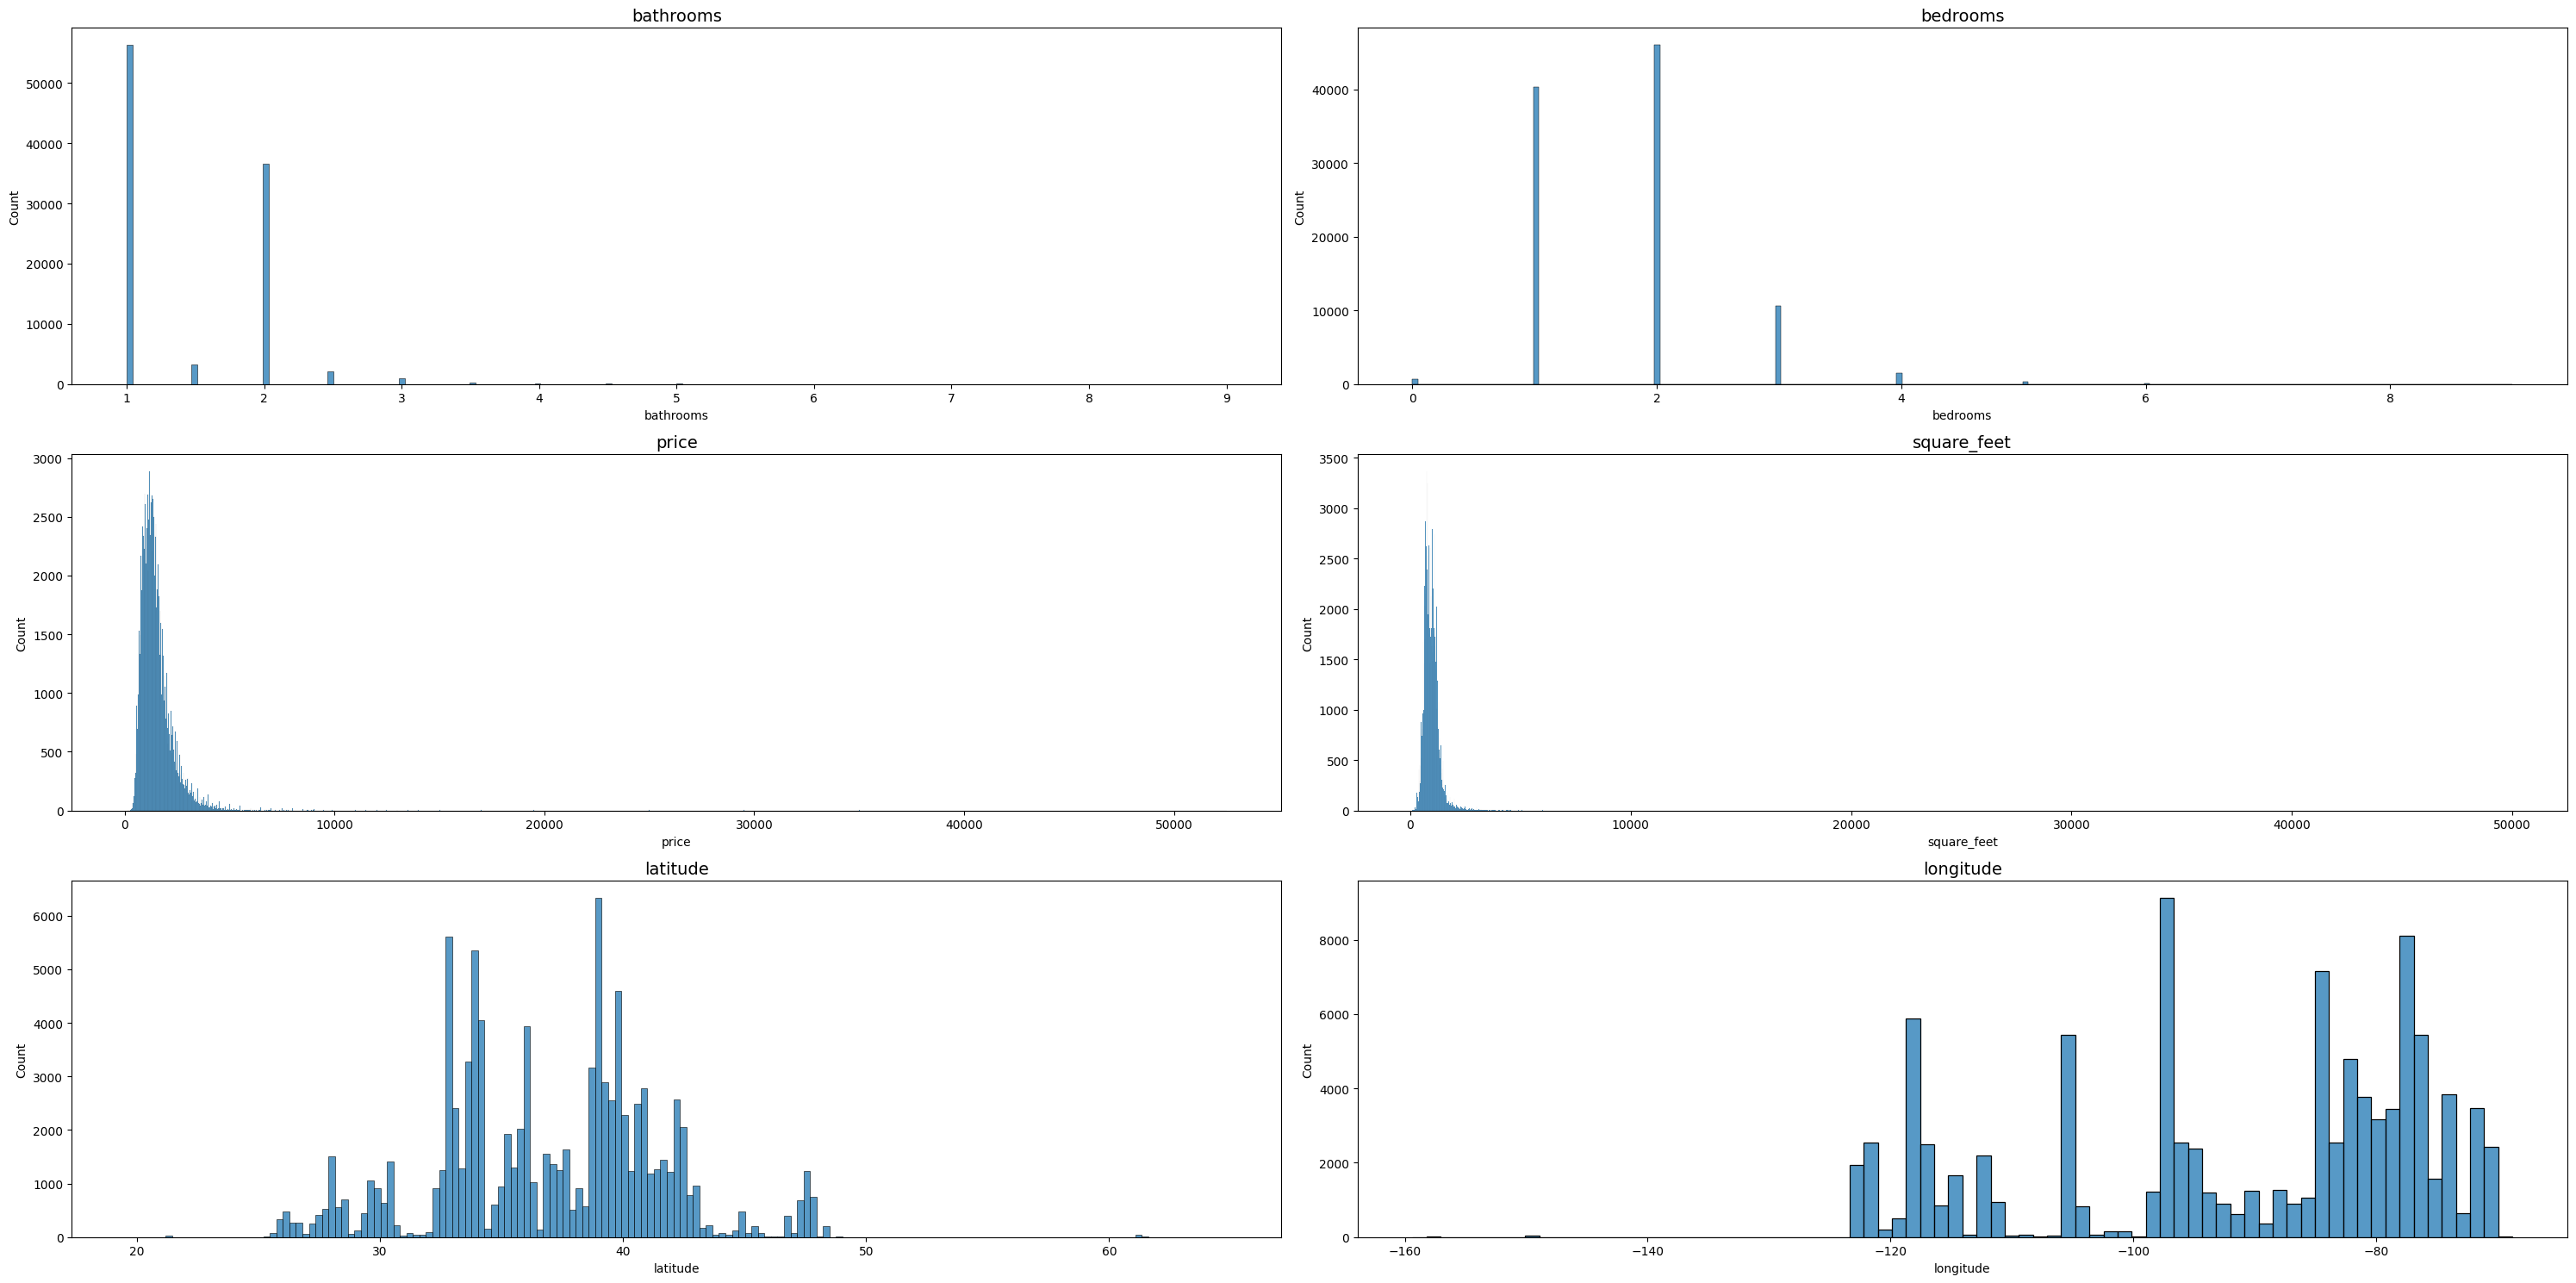

In [12]:
# bar plot for categorical columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))
axes = axes.flatten()

for ax, col in zip(axes, categorical_data.columns):
    sns.countplot(x=col, data=categorical_data, ax=ax)
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

# histogram for numerical columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))
axes = axes.flatten()

for ax, col in zip(axes, numerical_data.columns):
    sns.histplot(x=col, data=numerical_data, ax=ax)
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

<AxesSubplot: >

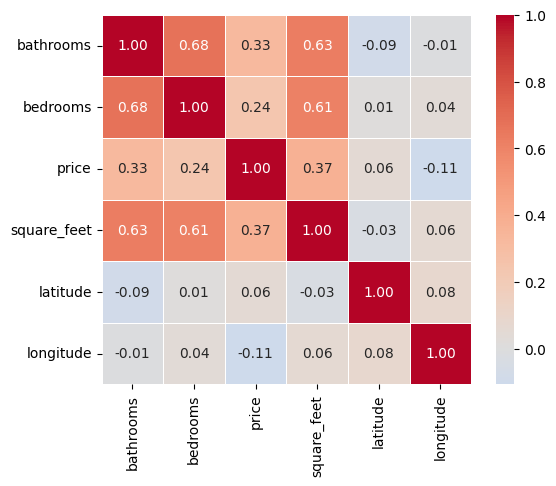

In [13]:
# correlation matrix
numerical_columns = data.select_dtypes(include=['number']).columns
corr = numerical_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=.5)

## Preprocess

In [14]:
# Removing unnecessary features 

# data = data.drop(columns =["id", "title", "body", "time", "price_display"])

In [15]:
# Remove high cardinality and constant columns
data = data.drop(columns=["category", "currency", "fee", "price_type"])             # constant
data = data.drop(columns=["amenities", "address", "cityname", "state", "source"])   # high cardinality

In [16]:
# Remove rows with missing target
data = data.dropna(subset=["price"])

# Remove no bedrooms
data = data[data["bedrooms"] > 0]

In [17]:
# get column types
data.columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
print(numerical_columns)

['has_photo', 'pets_allowed']
['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']


In [18]:
# categorical to one hot encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data

,bathrooms,bedrooms,price,square_feet,latitude,longitude,has_photo_Thumbnail,has_photo_Yes,"pets_allowed_Cats,Dogs","pets_allowed_Cats,Dogs,None",pets_allowed_Dogs,pets_allowed_None,pets_allowed_unknown
0,2.0000,2.0000,1920.0000,1076,34.0648,-84.0849,0,1,1,0,0,0,0
1,1.0000,1.0000,973.0000,965,32.4544,-93.7135,1,0,1,0,0,0,0
3,1.0000,1.0000,950.0000,722,27.8689,-97.2057,1,0,1,0,0,0,0
4,1.0000,2.0000,1275.0000,960,41.7588,-72.6148,1,0,0,0,0,0,1
5,2.0000,2.0000,1201.0000,1111,35.4718,-97.5180,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109484,1.0000,1.0000,799.0000,552,39.5358,-119.8373,0,1,1,0,0,0,0
109485,2.0000,2.0000,1596.0000,1183,27.9316,-82.3754,1,0,0,0,0,0,1
109487,2.0000,3.0000,1500.0000,1488,32.8471,-96.9648,1,0,1,0,0,0,0
109488,2.0000,2.0000,2864.0000,1016,42.2858,-71.3551,1,0,0,0,0,0,1


In [44]:
# split data
X = data.drop(columns=["price"])
y = data["price"]

# scaled target
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaled features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Train

In [45]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluate

MSE: 0.0349
RMSE: 0.1869
R2: 0.8152


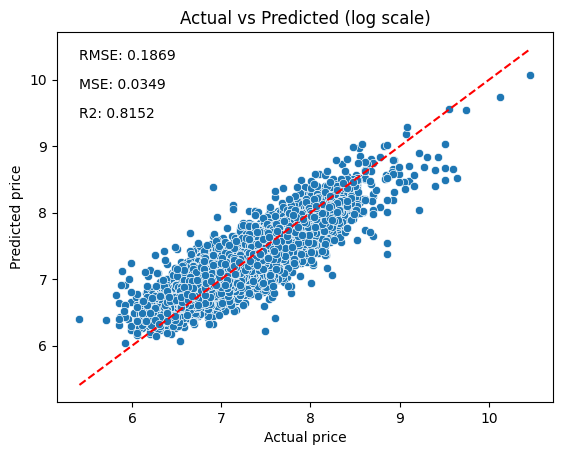

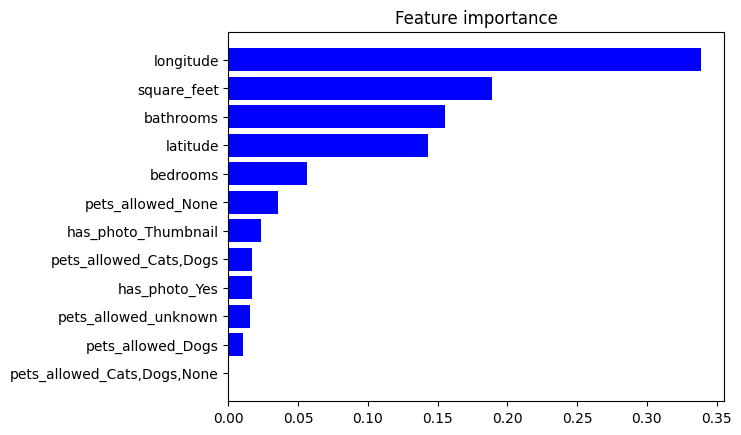

In [46]:
# score and plotting predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
sns.scatterplot(x=y_test, y=y_pred)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Actual vs Predicted (log scale)")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.text(min_val, max_val, f"RMSE: {rmse:.4f}", va='top')
plt.text(min_val, max_val-(max_val/24), f"MSE: {mse:.4f}", va='top')
plt.text(min_val, max_val-(max_val/12), f"R2: {r2:.4f}", va='top')
plt.show()

# important features
features = X.columns
importances = model.feature_importances_
ax = plt.axes()
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Feature importance')
plt.show()